### Imports

In [25]:
%load_ext autoreload
%autoreload 2

from jax import nn, vmap, lax, jit
from jax import numpy as jnp, random as jr
from jax import tree_util as jtu
from jax.scipy.special import gammaln, digamma

import numpy as np

from pymdp.envs import GridWorld, rollout
from pymdp.agent import Agent

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Grid world generative model
 
Here we will explore learning of the generative model inside a simple grid 7x7 world environment, where at each state agent can move into 4 possible directions. The agent can explore the environment for 100 time steps, after which it is reaturned to the original position. We will start first with an example where likelihood is fixed, and state transitions are unkown. Next we will explore the example where likelihood is unknown but the state transitions are known, and finally we will look at learning under joint uncertainty over likelihood and transitions (we would expect this case not to work in general with flat priors on both components). 


In [26]:
# size of the grid world
grid_shape = (7, 7)

# number of agents
batch_size = 20

env = GridWorld(shape=grid_shape, initial_position=(3,3), include_stay=False, batch_size=batch_size)

### Define KL divergence between Dirichlet distributions

In [27]:
@jit
def kl_div_dirichlet(alpha1, alpha2):
    alpha0 = alpha1.sum(1, keepdims=True)
    kl = gammaln(alpha0.squeeze(1)) - gammaln(alpha2.sum(1))
    kl += jnp.sum(gammaln(alpha2) - gammaln(alpha1) + (alpha1 - alpha2) * (digamma(alpha1) - digamma(alpha0)), 1)

    return kl

## Initialize different sets of agents using `Agent()` class, use a different `alpha` (action selection temperature) for each set

### Here, the agents have to learn B matrix, with A matrix being fixed to the true observation mapping of generative process, and flat prior oevr initial hidden states

In [ ]:
# create agent with A matrix being fixed to the A of the generative process
num_obs = [a.shape[1] for a in env.params['A']]
num_states = [b.shape[-2] for b in env.params['B']]

_A = [jnp.array(a) for a in env.params['A']]
C = [jnp.zeros((batch_size, num_obs[0]))]
pB = [jnp.ones_like(env.params['B'][0]) / num_states[0]]
_B = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pB)
_D = [jnp.ones((batch_size, num_states[0]))/num_states[0]]  # flat prior over initial states

agents = []
for i in range(5):
    agents.append( 
        Agent(
            _A,
            _B,
            C,
            _D,
            E=None,
            pA=None,
            pB=pB,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(batch_size),
            alpha=jnp.ones(batch_size) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=False,
            learn_B=True,
            learn_D=False,
            batch_size=batch_size,
            learning_mode="offline",
        )
    )

### Run multiple blocks of active inference on grid world for each batch of agents that was initialized different `alpha` values. 

#### Since the agents are using offline learning (`learning_mode = "offline"`), this means that parameter updates to the B tensors are performed at the end of each block.


In [35]:
pB_ground_truth = 1e4 * env.params['B'][0] + 1e-4
num_timesteps = 50
num_blocks = 40
key = jr.PRNGKey(0)
block_and_batch_keys = jr.split(key, num_blocks * (batch_size+1)).reshape((num_blocks, batch_size+1, -1))
divs = {i : [] for i in range(len(agents))}
for block in range(num_blocks):
    block_keys = block_and_batch_keys[block]
    for i, agent in enumerate(agents):
        _, env = env.reset(block_keys[:-1])
        last, info, env = jit(rollout, static_argnums=[2,] )(agent, env, num_timesteps, block_keys[-1])
        agents[i] = last['agent']
        divs[i].append(kl_div_dirichlet(last['agent'].pB[0], pB_ground_truth).sum(-1).mean(-1))

### Plot the KL divergence between the true parameters and believed parameters over time for the different groups of agents (agents with different levels of action stochasticity)

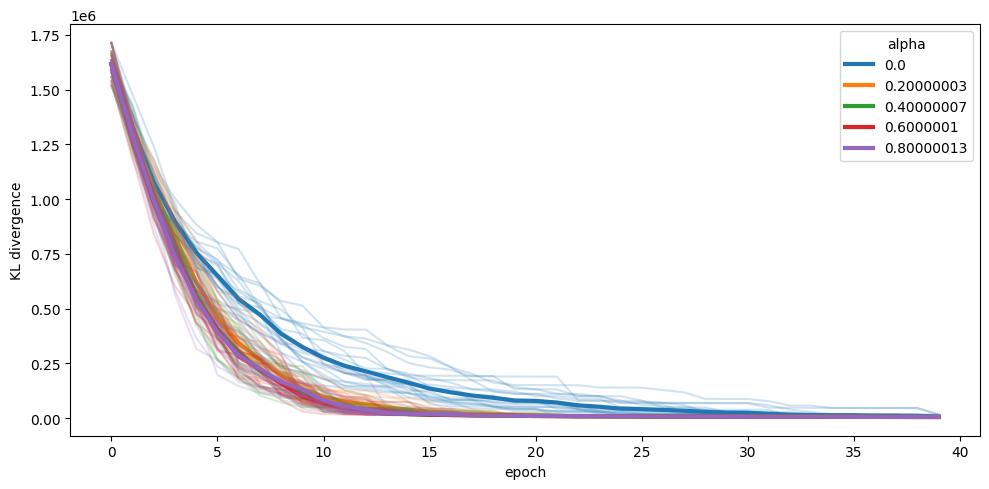

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
for i in range(len(agents)):
    p = axes.plot(jnp.stack(divs[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes.plot(jnp.stack(divs[i]), color=p[0].get_color(), alpha=.2)

axes.legend(title='alpha')
axes.set_ylabel('KL divergence')
axes.set_xlabel('epoch')
fig.tight_layout()

### Visualize the learned B tensor alongside the true environmental parameters after training

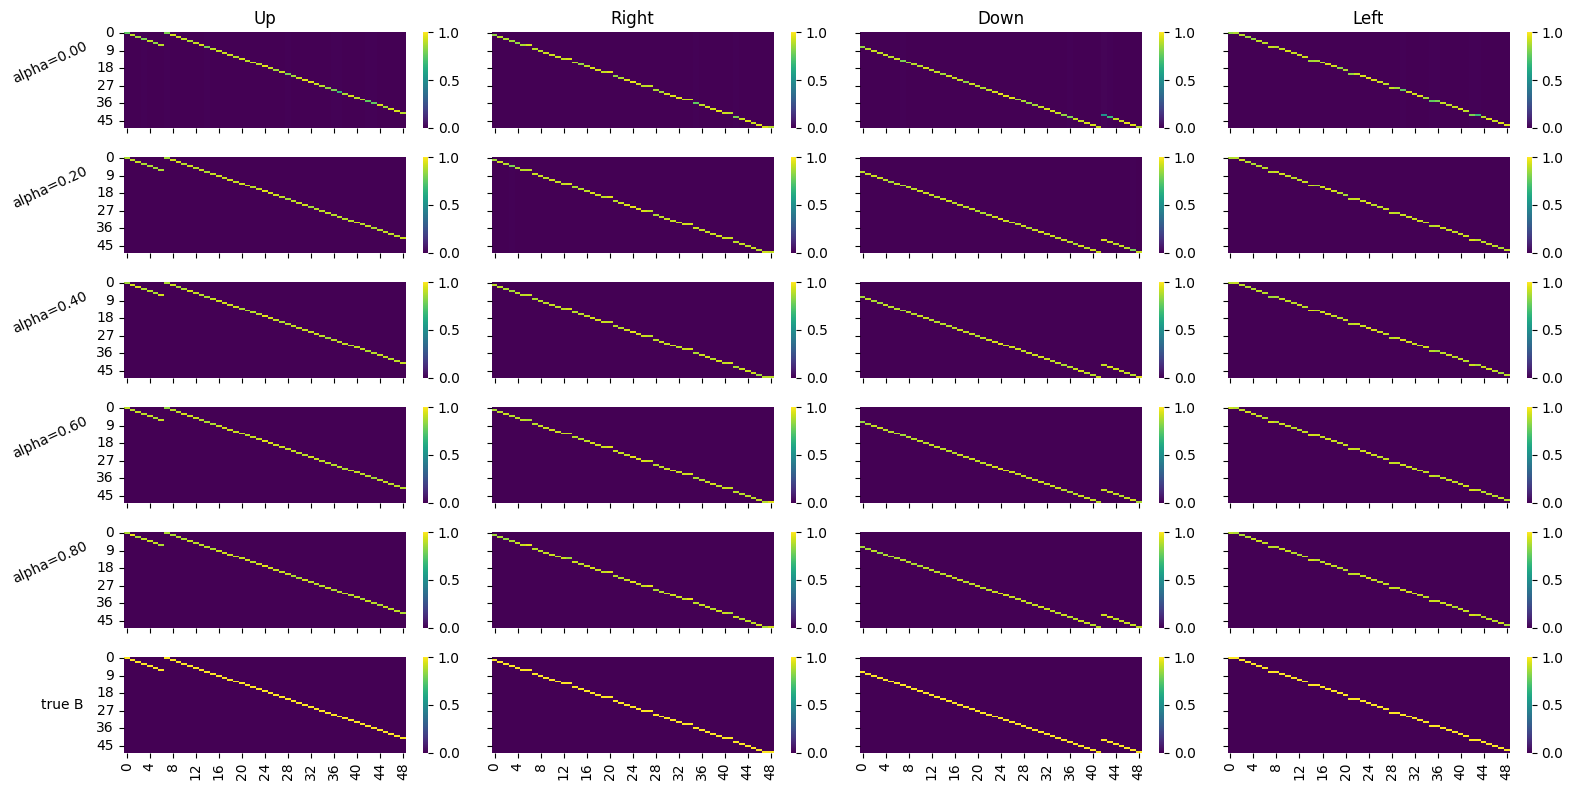

In [41]:
num_actions = env.params['B'][0].shape[-1]
base_labels = ["Up", "Right", "Down", "Left", "Stay"]
action_labels = base_labels[:num_actions]

row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')


fig, axes = plt.subplots(len(agents)+1, num_actions, figsize=(16, 8), sharex=True, sharey=True)


for i in range(num_actions):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.B[0][0, ..., i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['B'][0][0, ..., i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(action_labels[i])

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true B', rotation=0, labelpad=40, ha='left', va='center')


fig.tight_layout()


### Here, the agents have to learn A matrix, with B matrix being fixed to the true observation mapping of generative process, and precise (and accurate) prior over initial hidden states

In [ ]:
C = [jnp.zeros((batch_size, num_obs[0]))]
pA = [jnp.ones_like(a) / a.shape[1] for a in env.params['A']]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)
B = [jnp.array(b) for b in env.params['B']]
D = [jnp.array(d) for d in env.params['D']]  

agents = []
for i in range(5):
    agents.append( 
        Agent(
            _A,
            B,
            C,
            D,
            E=None,
            pA=pA,
            pB=None,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(batch_size),
            alpha=jnp.ones(batch_size) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
            batch_size=batch_size,
            learning_mode="offline",
        )
    )

### Run multiple blocks of active inference on grid world for each batch of agents that was initialized different `alpha` values. 

#### Since the agents are using offline learning (`learning_mode = "offline"`), this means that parameter updates to the A matrix are performed at the end of each block.


In [43]:
pA_ground_truth = 1e4 * env.params['A'][0] + 1e-4
num_timesteps = 50
num_blocks = 20
key = jr.PRNGKey(0)
block_and_batch_keys = jr.split(key, num_blocks * (batch_size+1)).reshape((num_blocks, batch_size+1, -1))

divs = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    block_keys = block_and_batch_keys[block]
    for i, agent in enumerate(agents):
        _, env = env.reset(block_keys[:-1])
        last, info, env = jit(rollout, static_argnums=[2,] )(agent, env, num_timesteps, block_keys[-1])
        agents[i] = last['agent']
        divs[i].append(kl_div_dirichlet(agents[i].pA[0], pA_ground_truth).mean(-1))

### Plot the KL divergence between the true parameters and believed parameters over time for the different groups of agents (agents with different levels of action stochasticity)

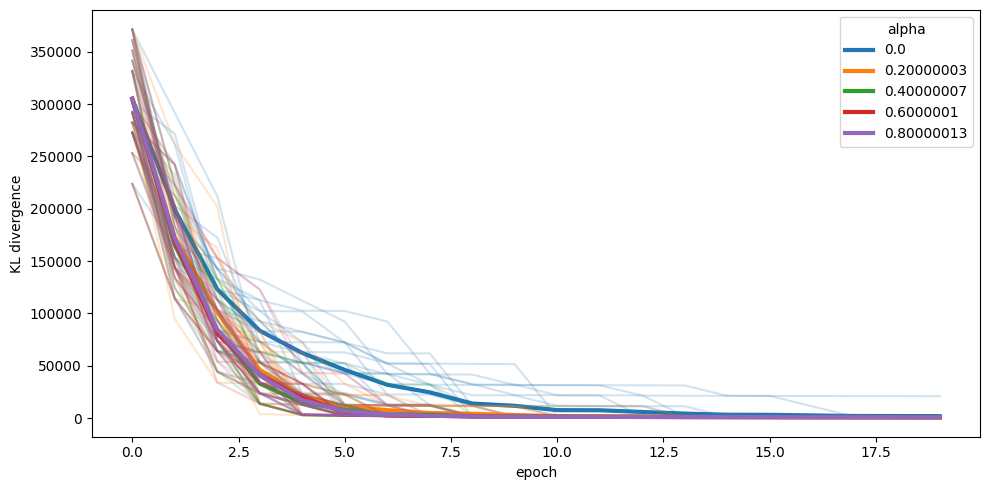

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
for i in range(len(agents)):
    p = axes.plot(jnp.stack(divs[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes.plot(jnp.stack(divs[i]), color=p[0].get_color(), alpha=.2)

axes.legend(title='alpha')
axes.set_ylabel('KL divergence')
axes.set_xlabel('epoch')
fig.tight_layout()

### Visualize the learned A matrices alongside the true environmental parameters after training

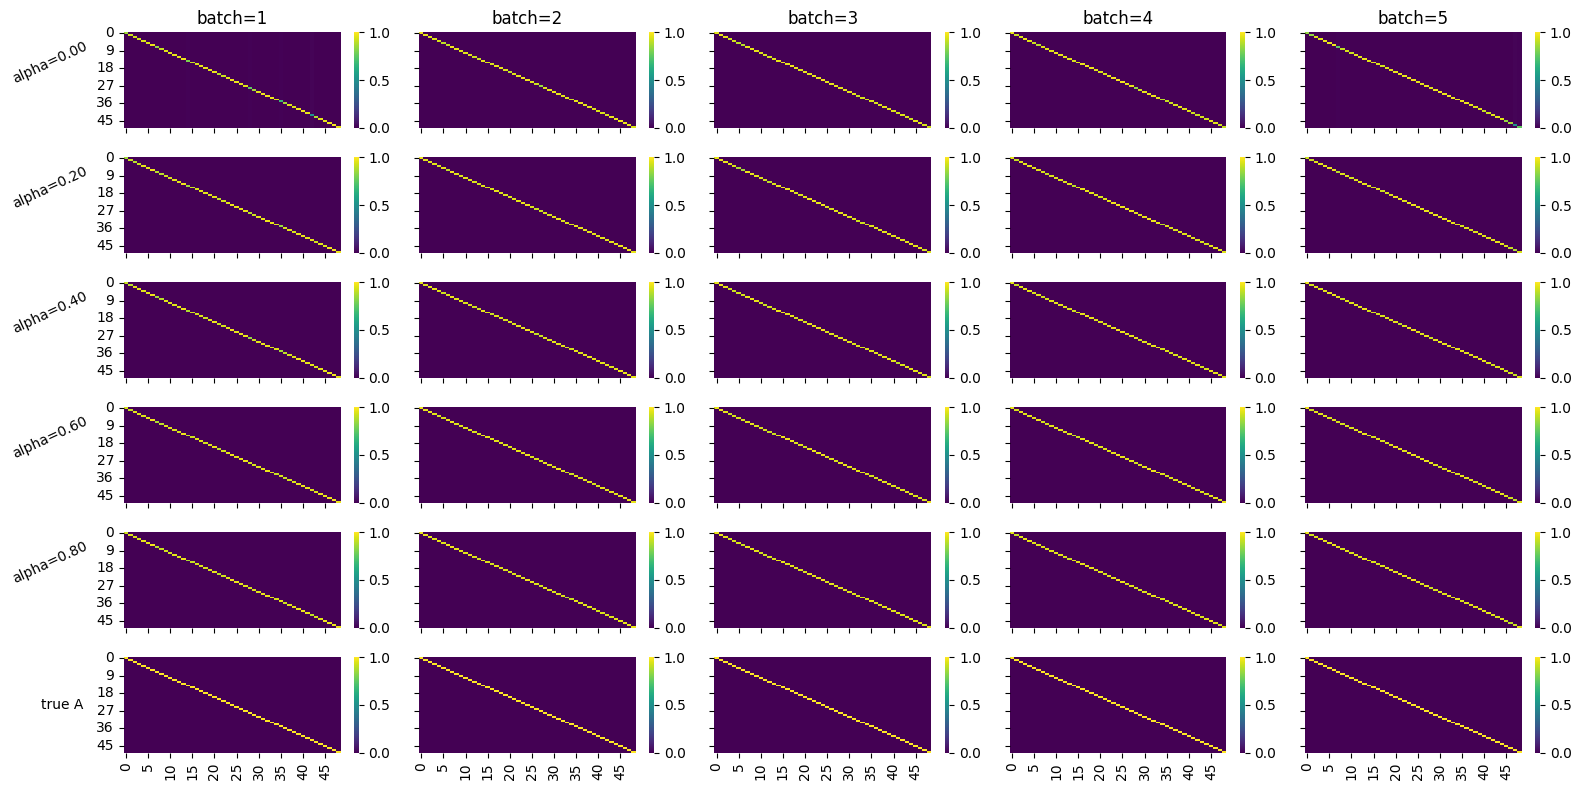

In [45]:
n_batches_to_show = min(5, agents[0].A[0].shape[0])
num_rows = len(agents) + 1
row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')

fig, axes = plt.subplots(num_rows, n_batches_to_show, figsize=(16, 8), sharex=True, sharey=True)

for i in range(n_batches_to_show):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['A'][0][i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(f'batch={i + 1}')

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true A', rotation=0, labelpad=40, ha='left', va='center')

fig.tight_layout()


### Here, once again the agents have to learn the A matrix, with B matrix being fixed to the true B matrix of generative process. This time, agents have a flat prior over initial hidden states

In [51]:
# create agent with B matrix being fixed to the B of the generative process, and precise initial beliefs about hidden states
C = [jnp.zeros((batch_size, num_obs[0]))]
pA = [jnp.ones_like(a) / a.shape[1] for a in env.params['A']]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)
B = [jnp.array(b) for b in env.params['B']]
_D = [jnp.ones((batch_size, num_states[0]))/num_states[0]]  # flat prior over initial states

agents = []
for i in range(5):
    agents.append( 
        Agent(
            _A,
            B,
            C,
            _D,
            E=None,
            pA=pA,
            pB=None,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(batch_size),
            alpha=jnp.ones(batch_size) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
            batch_size=batch_size,
            learning_mode="offline",
        )
    )

### Run multiple blocks of active inference on grid world for each batch of agents that was initialized different `alpha` values. 

#### Since the agents are using offline learning (`learning_mode = "offline"`), this means that parameter updates to the A matrix are performed at the end of each block.


In [52]:
pA_ground_truth = 1e4 * env.params['A'][0] + 1e-4
num_timesteps = 50
num_blocks = 20
key = jr.PRNGKey(0)
block_and_batch_keys = jr.split(key, num_blocks * (batch_size+1)).reshape((num_blocks, batch_size+1, -1))

divs = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    block_keys = block_and_batch_keys[block]
    for i, agent in enumerate(agents):
        _, env = env.reset(block_keys[:-1])
        last, info, env = jit(rollout, static_argnums=[2,] )(agent, env, num_timesteps, block_keys[-1])
        agents[i] = last['agent']
        divs[i].append(kl_div_dirichlet(agents[i].pA[0], pA_ground_truth).mean(-1))

### Plot the KL divergence between the true parameters and believed parameters over time for the different groups of agents (agents with different levels of action stochasticity)

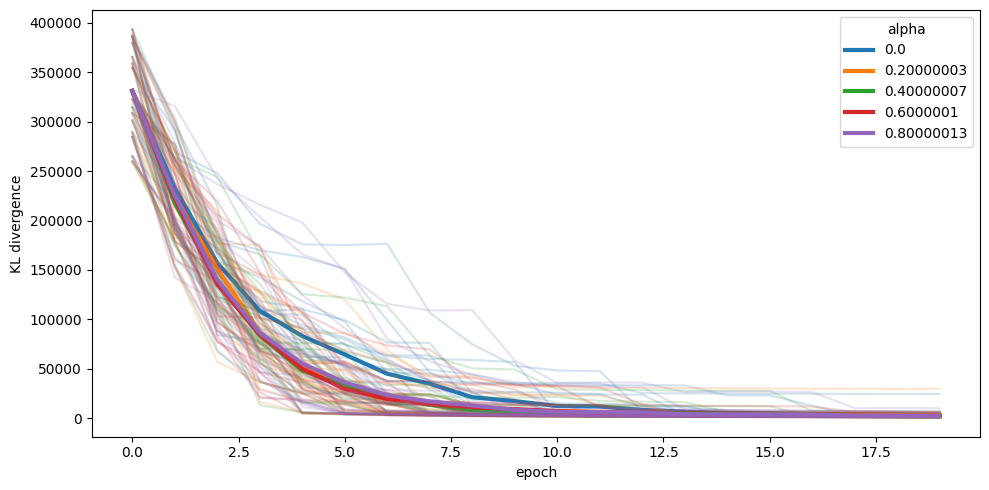

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
for i in range(len(agents)):
    p = axes.plot(jnp.stack(divs[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes.plot(jnp.stack(divs[i]), color=p[0].get_color(), alpha=.2)

axes.legend(title='alpha')
axes.set_ylabel('KL divergence')
axes.set_xlabel('epoch')
fig.tight_layout()

### Visualize the learned A matrices alongside the true environmental parameters after training

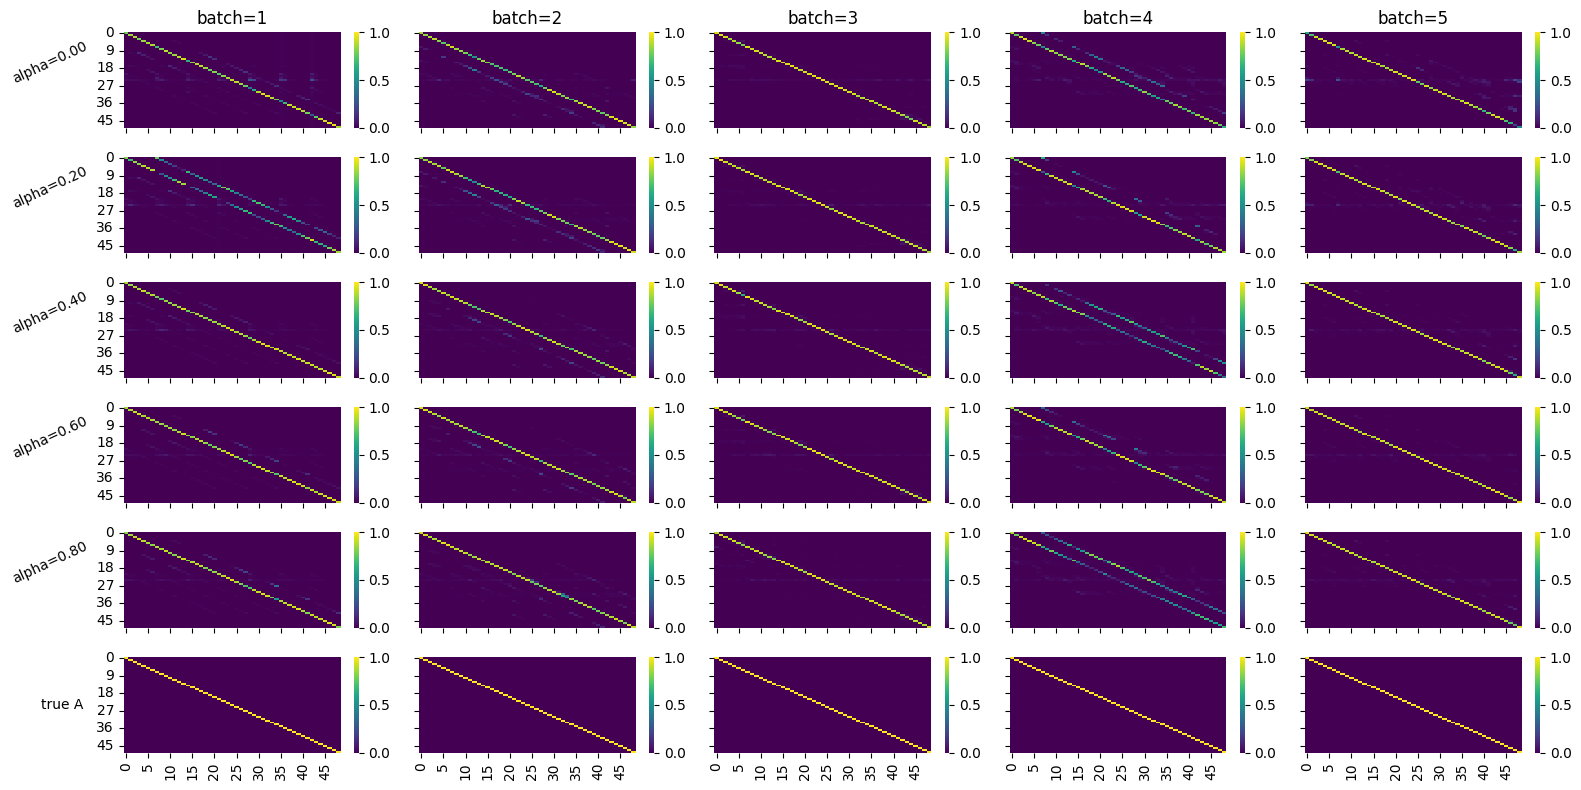

In [54]:
n_batches_to_show = min(5, agents[0].A[0].shape[0])
num_rows = len(agents) + 1
row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')

fig, axes = plt.subplots(num_rows, n_batches_to_show, figsize=(16, 8), sharex=True, sharey=True)

for i in range(n_batches_to_show):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['A'][0][i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(f'batch={i + 1}')

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true A', rotation=0, labelpad=40, ha='left', va='center')

fig.tight_layout()


### Here, once again the agents have to learn the A matrix, but now have a flat/uninformative prior over the B matrix
#### We use a precise and accurate prior over hidden states

In [55]:
C = [jnp.zeros((batch_size, num_obs[0]))]
pA = [jnp.ones_like(env.params["A"][0]) / num_obs[0]]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)
pB = [jnp.ones_like(env.params["B"][0]) / num_states[0]]
_B = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pB)
D = [jnp.array(d) for d in env.params['D']]

agents = []
for i in range(5):
    agents.append( 
        Agent(
            _A,
            _B,
            C,
            D,
            E=None,
            pA=pA,
            pB=pB,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(batch_size),
            alpha=jnp.ones(batch_size) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
            batch_size=batch_size,
            learning_mode="offline",
        )
    )

### Run multiple blocks of active inference on grid world for each batch of agents that was initialized different `alpha` values. 

#### Since the agents are using offline learning (`learning_mode = "offline"`), this means that parameter updates to the A matrix are performed at the end of each block.

In [56]:
pA_ground_truth = 1e4 * env.params['A'][0] + 1e-4
pB_ground_truth = 1e4 * env.params['B'][0] + 1e-4
num_timesteps = 50
num_blocks = 100
key = jr.PRNGKey(0)
block_and_batch_keys = jr.split(key, num_blocks * (batch_size+1)).reshape((num_blocks, batch_size+1, -1))

divs1 = {i: [] for i in range(len(agents))}
divs2 = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    block_keys = block_and_batch_keys[block]
    for i, agent in enumerate(agents):
        _, env = env.reset(block_keys[:-1])
        last, info, env = jit(rollout, static_argnums=[2,] )(agent, env, num_timesteps, block_keys[-1])
        agents[i] = last['agent']
        divs1[i].append(kl_div_dirichlet(agents[i].pA[0], pA_ground_truth).mean(-1))
        divs2[i].append(kl_div_dirichlet(agents[i].pB[0], pB_ground_truth).sum(-1).mean(-1))

### Plot the KL divergence between the true parameters and believed parameters over time for the different groups of agents (agents with different levels of action stochasticity)

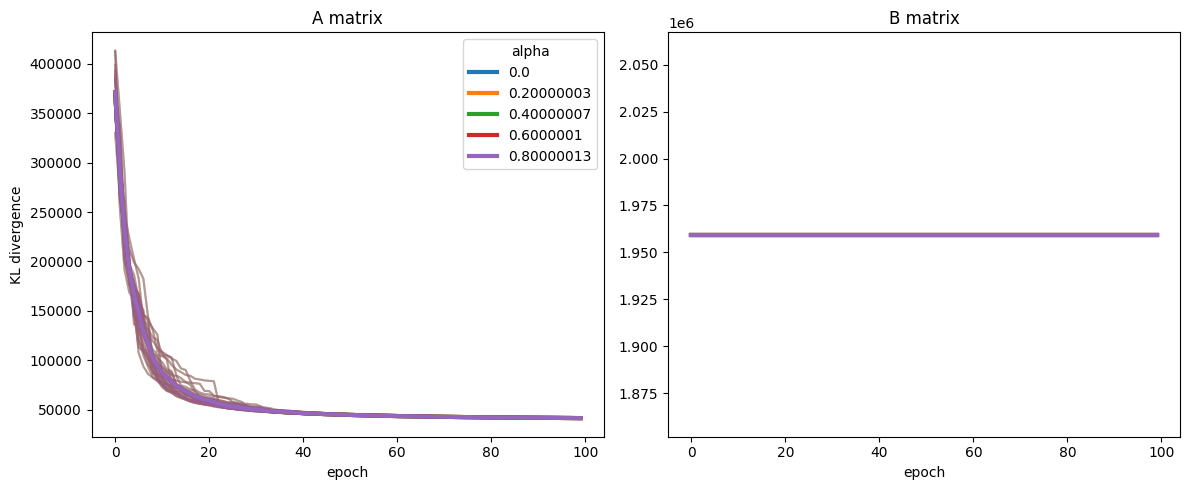

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)
for i in range(len(agents)):
    p = axes[0].plot(jnp.stack(divs1[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[0].plot(jnp.stack(divs1[i]), color=p[0].get_color(), alpha=.2)

    p = axes[1].plot(jnp.stack(divs2[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[1].plot(jnp.stack(divs2[i]), color=p[0].get_color(), alpha=.2)

axes[0].legend(title='alpha')
axes[0].set_ylabel('KL divergence')
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[0].set_title('A matrix')
axes[1].set_title('B matrix')
fig.tight_layout()

### Visualize the learned A matrices alongside the true environmental parameters after training

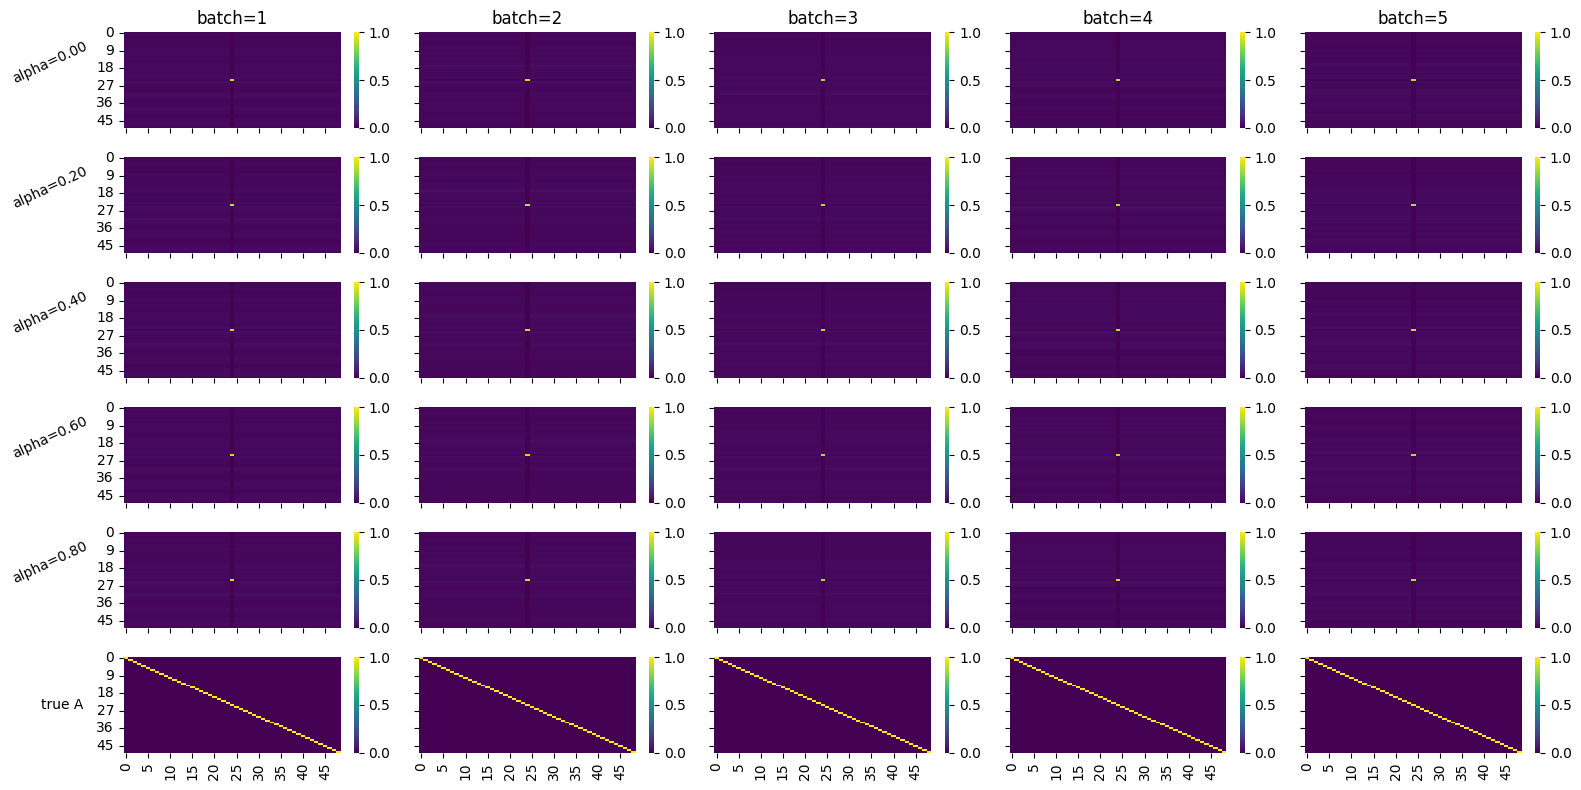

In [58]:
n_batches_to_show = min(5, agents[0].A[0].shape[0])
num_rows = len(agents) + 1
row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')

fig, axes = plt.subplots(num_rows, n_batches_to_show, figsize=(16, 8), sharex=True, sharey=True)

for i in range(n_batches_to_show):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['A'][0][i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(f'batch={i + 1}')

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true A', rotation=0, labelpad=40, ha='left', va='center')

fig.tight_layout()


### Visualize the B tensor (just the expected value of the posterior which in absence of learning is same as the prior) alongside the true environmental parameters after training

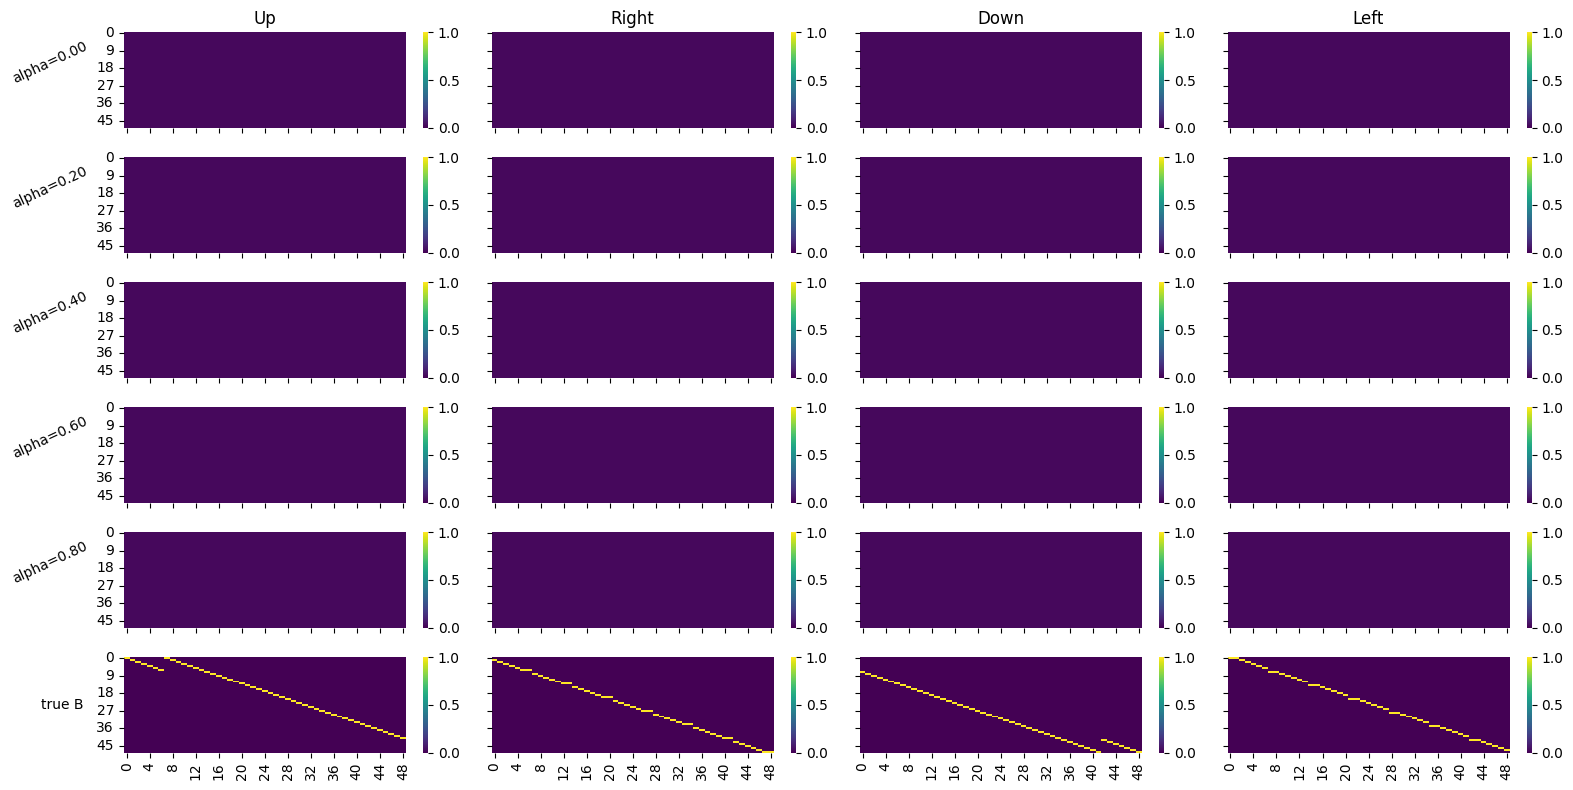

In [61]:
num_actions = env.params['B'][0].shape[-1]
base_labels = ["Up", "Right", "Down", "Left", "Stay"]
action_labels = base_labels[:num_actions]

row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')


fig, axes = plt.subplots(len(agents)+1, num_actions, figsize=(16, 8), sharex=True, sharey=True)


for i in range(num_actions):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.B[0][0, ..., i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['B'][0][0, ..., i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(action_labels[i])

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true B', rotation=0, labelpad=40, ha='left', va='center')


fig.tight_layout()


### Here, once again the agents have to learn the A matrix, but now have an informative prior over the B matrix: we fix it to the expected transition distribution under a flat prior over actions, i.e. the agent knows generally that motion on the grid is restricted to the locality, but have no sense of how particular actions relate to particular transitions.
#### We use a flat prior over initial hidden states

In [68]:
C = [jnp.zeros((batch_size, num_obs[0]))]
pA = [jnp.ones_like(env.params["A"][0]) / num_obs[0]]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)
B_collapsed_actions = jnp.clip(env.params['B'][0].sum(-1), max=1)
pB = [jnp.expand_dims(B_collapsed_actions, -1) + jnp.ones_like(env.params['B'][0]) / num_states[0]]
_B = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pB)

agents = []
for i in range(5):
    agents.append( 
        Agent(
            _A,
            _B,
            C,
            _D,
            E=None,
            pA=pA,
            pB=pB,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(batch_size),
            alpha=jnp.ones(batch_size) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
            batch_size=batch_size,
            learning_mode="offline",
        )
    )

### Run multiple blocks of active inference on grid world for each batch of agents that was initialized different `alpha` values. 

#### Since the agents are using offline learning (`learning_mode = "offline"`), this means that parameter updates to the A matrix are performed at the end of each block.

In [69]:
pA_ground_truth = 1e4 * env.params['A'][0] + 1e-4
pB_ground_truth = 1e4 * env.params['B'][0] + 1e-4
num_timesteps = 50
num_blocks = 100
key = jr.PRNGKey(0)
block_and_batch_keys = jr.split(key, num_blocks * (batch_size+1)).reshape((num_blocks, batch_size+1, -1))

divs1 = {i: [] for i in range(len(agents))}
divs2 = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    block_keys = block_and_batch_keys[block]
    for i, agent in enumerate(agents):
        _, env = env.reset(block_keys[:-1])
        last, info, env = jit(rollout, static_argnums=[2,] )(agent, env, num_timesteps, block_keys[-1])
        agents[i] = last['agent']
        divs1[i].append(kl_div_dirichlet(agents[i].pA[0], pA_ground_truth).mean(-1))
        divs2[i].append(kl_div_dirichlet(agents[i].pB[0], pB_ground_truth).sum(-1).mean(-1))

### Plot the KL divergence between the true parameters and believed parameters over time for the different groups of agents (agents with different levels of action stochasticity)

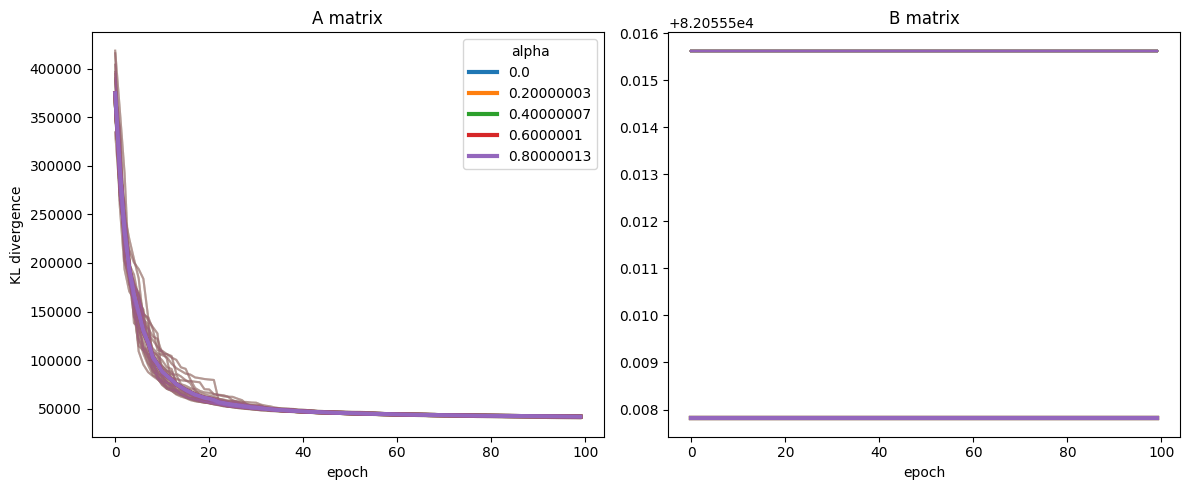

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)
for i in range(len(agents)):
    p = axes[0].plot(jnp.stack(divs1[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[0].plot(jnp.stack(divs1[i]), color=p[0].get_color(), alpha=.2)

    p = axes[1].plot(jnp.stack(divs2[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[1].plot(jnp.stack(divs2[i]), color=p[0].get_color(), alpha=.2)

axes[0].legend(title='alpha')
axes[0].set_ylabel('KL divergence')
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[0].set_title('A matrix')
axes[1].set_title('B matrix')
fig.tight_layout()

### Visualize the learned A matrices alongside the true environmental parameters after training

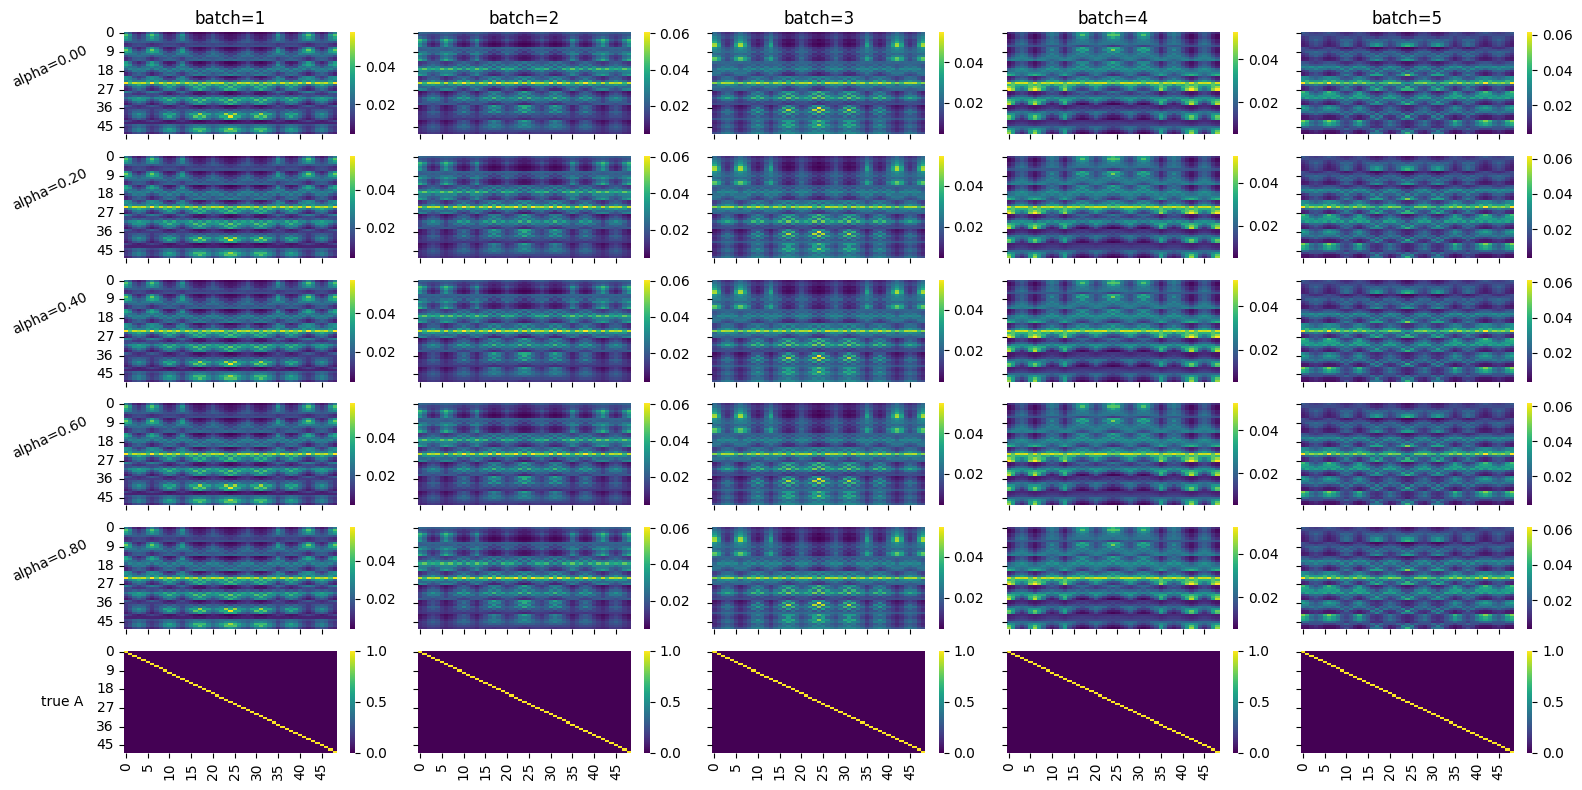

In [74]:
n_batches_to_show = min(5, agents[0].A[0].shape[0])
num_rows = len(agents) + 1
row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')

fig, axes = plt.subplots(num_rows, n_batches_to_show, figsize=(16, 8), sharex=True, sharey=True)

for i in range(n_batches_to_show):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis')
    sns.heatmap(env.params['A'][0][i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(f'batch={i + 1}')

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true A', rotation=0, labelpad=40, ha='left', va='center')

fig.tight_layout()


### Visualize the B tensor (just the expected value of the posterior which in absence of learning is same as the prior) alongside the true environmental parameters after training

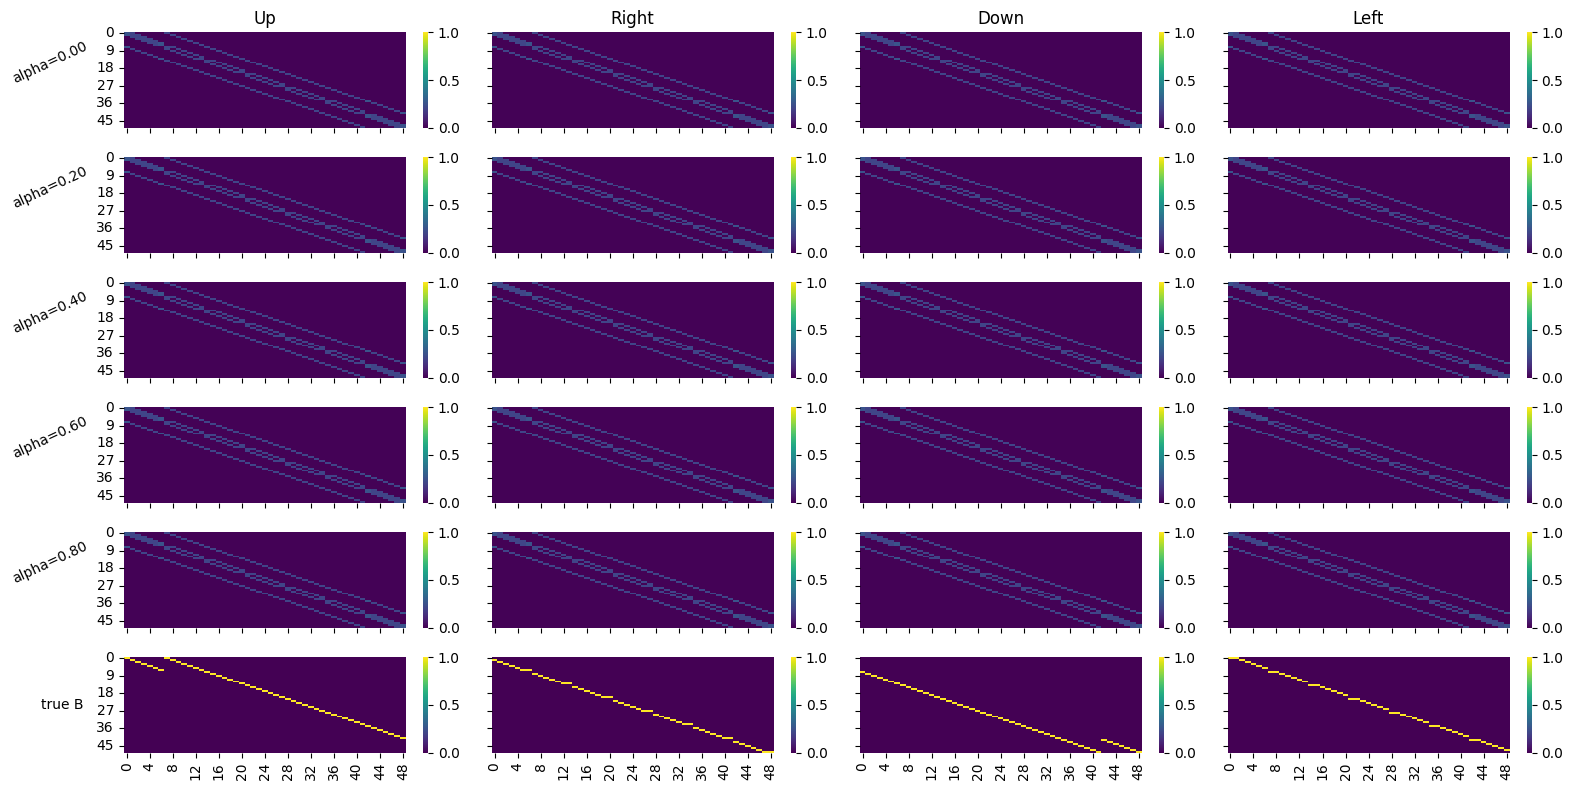

In [75]:
num_actions = env.params['B'][0].shape[-1]
base_labels = ["Up", "Right", "Down", "Left", "Stay"]
action_labels = base_labels[:num_actions]

row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')


fig, axes = plt.subplots(len(agents)+1, num_actions, figsize=(16, 8), sharex=True, sharey=True)


for i in range(num_actions):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.B[0][0, ..., i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['B'][0][0, ..., i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(action_labels[i])

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true B', rotation=0, labelpad=40, ha='left', va='center')


fig.tight_layout()


### Here, once again the agents have to learn the A matrix, but now have an informative prior over the B matrix: we fix it to the expected transition distribution under a flat prior over actions, i.e. the agent knows generally that motion on the grid is restricted to the locality, but have no sense of how particular actions relate to particular transitions.
#### We use a precise and accruate prior over initial hidden states

In [77]:
C = [jnp.zeros((batch_size, num_obs[0]))]
pA = [jnp.ones_like(env.params["A"][0]) / num_obs[0]]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)
B_collapsed_actions = jnp.clip(env.params['B'][0].sum(-1), max=1)
pB = [jnp.expand_dims(B_collapsed_actions, -1) + jnp.ones_like(env.params['B'][0]) / num_states[0]]
_B = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pB)

agents = []
for i in range(5):
    agents.append( 
        Agent(
            _A,
            _B,
            C,
            D,
            E=None,
            pA=pA,
            pB=pB,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(batch_size),
            alpha=jnp.ones(batch_size) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
            batch_size=batch_size,
            learning_mode="offline",
        )
    )

### Run multiple blocks of active inference on grid world for each batch of agents that was initialized different `alpha` values. 

#### Since the agents are using offline learning (`learning_mode = "offline"`), this means that parameter updates to the A matrix are performed at the end of each block.

In [78]:
pA_ground_truth = 1e4 * env.params['A'][0] + 1e-4
pB_ground_truth = 1e4 * env.params['B'][0] + 1e-4
num_timesteps = 50
num_blocks = 100
key = jr.PRNGKey(0)
block_and_batch_keys = jr.split(key, num_blocks * (batch_size+1)).reshape((num_blocks, batch_size+1, -1))

divs1 = {i: [] for i in range(len(agents))}
divs2 = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    block_keys = block_and_batch_keys[block]
    for i, agent in enumerate(agents):
        _, env = env.reset(block_keys[:-1])
        last, info, env = jit(rollout, static_argnums=[2,] )(agent, env, num_timesteps, block_keys[-1])
        agents[i] = last['agent']
        divs1[i].append(kl_div_dirichlet(agents[i].pA[0], pA_ground_truth).mean(-1))
        divs2[i].append(kl_div_dirichlet(agents[i].pB[0], pB_ground_truth).sum(-1).mean(-1))

### Plot the KL divergence between the true parameters and believed parameters over time for the different groups of agents (agents with different levels of action stochasticity)

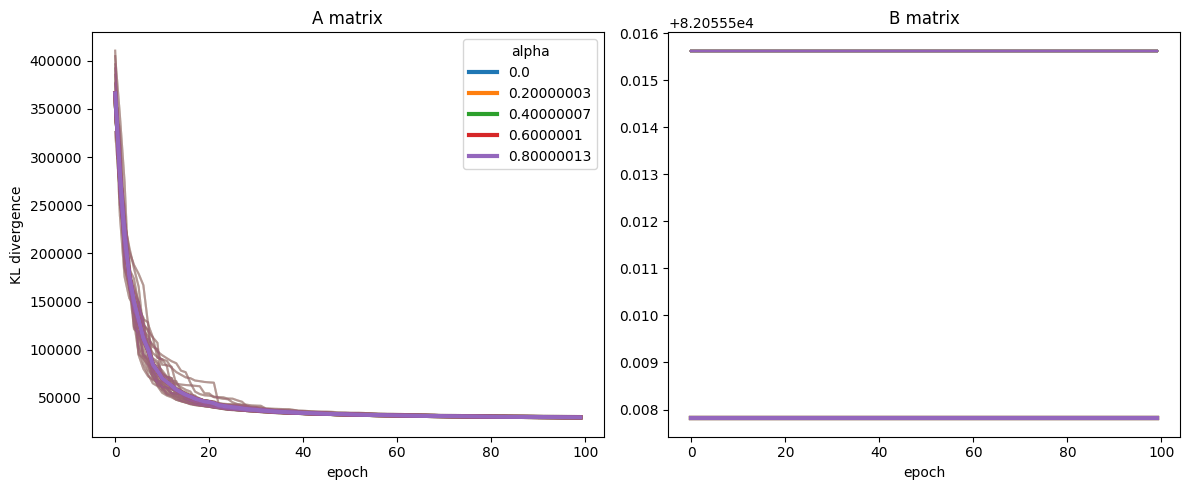

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)
for i in range(len(agents)):
    p = axes[0].plot(jnp.stack(divs1[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[0].plot(jnp.stack(divs1[i]), color=p[0].get_color(), alpha=.2)

    p = axes[1].plot(jnp.stack(divs2[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[1].plot(jnp.stack(divs2[i]), color=p[0].get_color(), alpha=.2)

axes[0].legend(title='alpha')
axes[0].set_ylabel('KL divergence')
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[0].set_title('A matrix')
axes[1].set_title('B matrix')
fig.tight_layout()

### Visualize the learned A matrices alongside the true environmental parameters after training

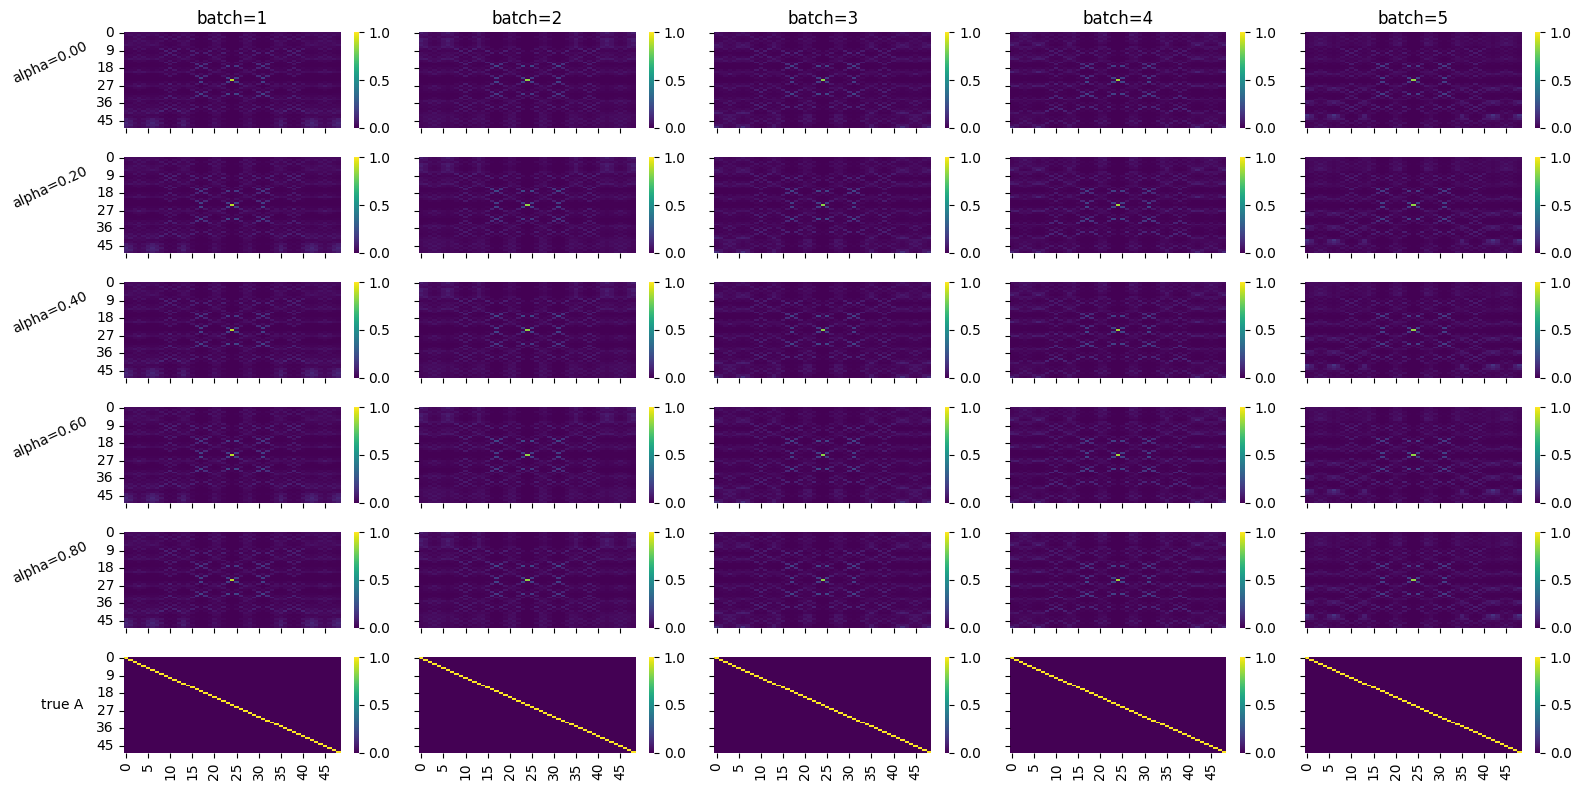

In [82]:
n_batches_to_show = min(5, agents[0].A[0].shape[0])
num_rows = len(agents) + 1
row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')

fig, axes = plt.subplots(num_rows, n_batches_to_show, figsize=(16, 8), sharex=True, sharey=True)

for i in range(n_batches_to_show):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['A'][0][i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(f'batch={i + 1}')

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true A', rotation=0, labelpad=40, ha='left', va='center')

fig.tight_layout()


### Visualize the B tensor (just the expected value of the posterior which in absence of learning is same as the prior) alongside the true environmental parameters after training

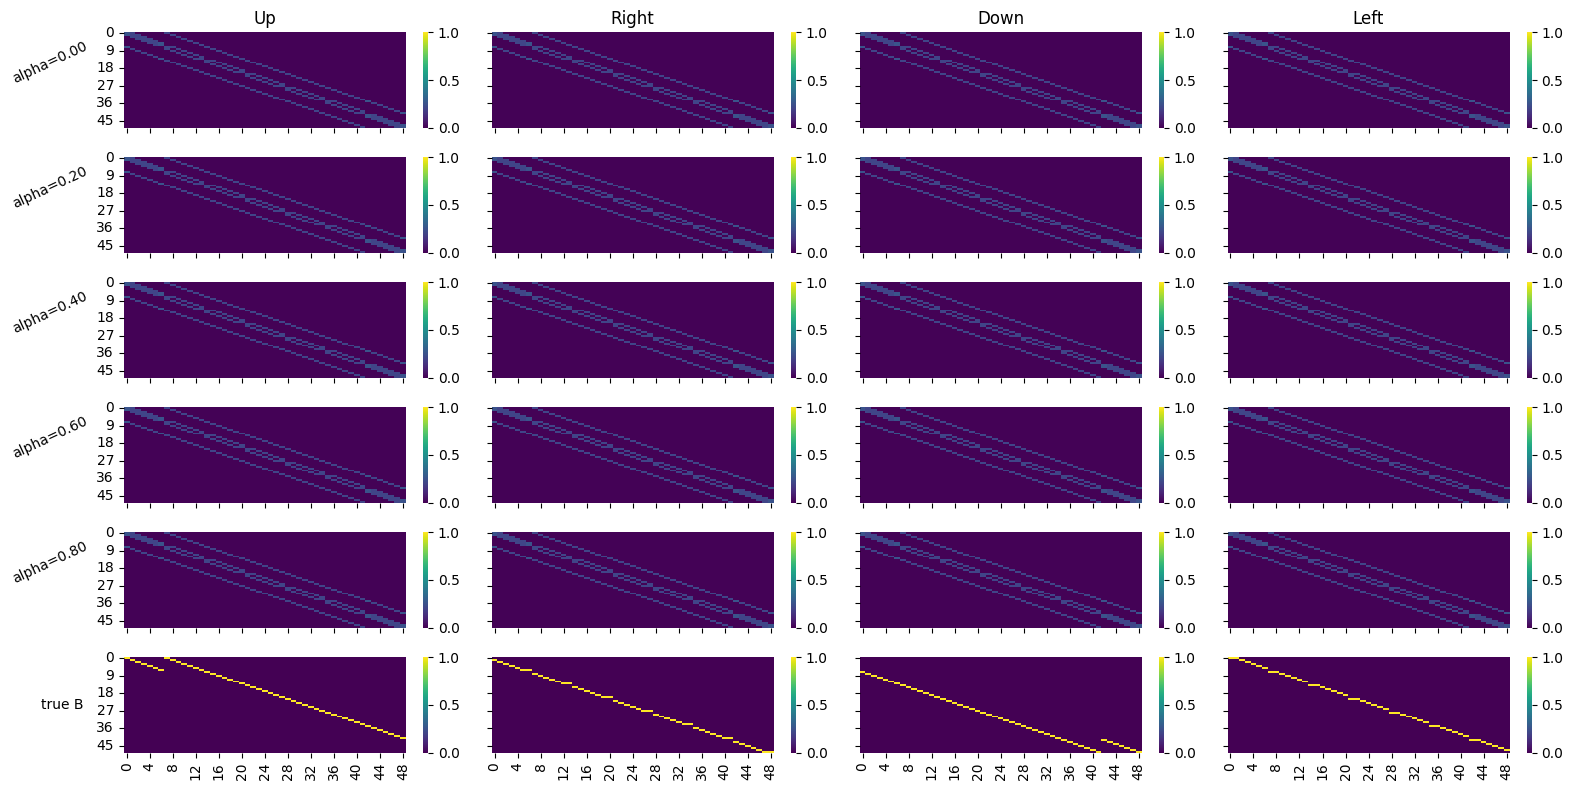

In [81]:
num_actions = env.params['B'][0].shape[-1]
base_labels = ["Up", "Right", "Down", "Left", "Stay"]
action_labels = base_labels[:num_actions]

row_labels = []
for agent in agents:
    alpha_value = float(agent.alpha.mean(0).squeeze())
    row_labels.append(f'alpha={alpha_value:.2f}')


fig, axes = plt.subplots(len(agents)+1, num_actions, figsize=(16, 8), sharex=True, sharey=True)


for i in range(num_actions):
    for j, agent in enumerate(agents):
        sns.heatmap(agent.B[0][0, ..., i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(env.params['B'][0][0, ..., i], ax=axes[-1, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(action_labels[i])

for j, label in enumerate(row_labels):
    axes[j, 0].set_ylabel(label, rotation=25, labelpad=60, ha='left', va='center')
axes[-1, 0].set_ylabel('true B', rotation=0, labelpad=40, ha='left', va='center')


fig.tight_layout()
